In [1]:
import os
import pathlib
import sys

default_dir_path = str(pathlib.Path(os.getcwd()).parent.absolute())

sys.path.append(default_dir_path)

from properties import ApplicationProperties

[2020-12-17 15:33:35,625][INFO][properties.py:22] Complete to apply the random seed, RANDOM_SEED : 777


In [2]:
from torch import optim
from torch.nn import functional as F
import torch

from dataset.factory import DatasetFactory
from dataset.nsl_kdd_dataset import NSLKDDDataFrameFactory, NSLKDDDataset
from domain.criterion import Criterion
from domain.hyperparameters import Hyperparameters
from domain.metadata import ModelFileMetadata
from logger import logger
from model.factory import ModelFactory
from trainer.base import TrainerBase
from trainer.factory import TrainerFactory

In [3]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm

In [4]:
device = "cpu"
data_name = "nsl_kdd_outlier"
model_name = "oesae_margin05"
n_epoch = 1000

In [5]:
dataset_factory = DatasetFactory.create(data_name=data_name)

[2020-12-17 15:33:40,388][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : train
[2020-12-17 15:33:40,485][INFO][nsl_kdd_dataset.py:98] Success to load dataset dataframe : test
[2020-12-17 15:33:40,906][INFO][nsl_kdd_dataset.py:110] Success to load dataset dataframe : entire
[2020-12-17 15:33:41,849][INFO][nsl_kdd_dataset.py:164] Entire data size : 148517
[2020-12-17 15:33:41,853][INFO][nsl_kdd_dataset.py:165] Normal data size : 77054
[2020-12-17 15:33:41,857][INFO][nsl_kdd_dataset.py:166] Abnormal data size : 7146
[2020-12-17 15:33:41,859][INFO][nsl_kdd_dataset.py:167] Outlier data size : 7146
[2020-12-17 15:33:41,862][INFO][nsl_kdd_dataset.py:168] Normal test data size : 7146
[2020-12-17 15:33:41,864][INFO][nsl_kdd_dataset.py:169] Training data size : 69908
[2020-12-17 15:33:41,867][INFO][nsl_kdd_dataset.py:170] Test data size : 14292
[2020-12-17 15:33:42,478][INFO][factory.py:109] Success to fit data with scaling
[2020-12-17 15:33:42,667][INFO][factory.py:118] Succes

In [6]:
train_dataloader, outlier_dataloader = dataset_factory.train_dataloader
val_dataloader = dataset_factory.val_dataloader

In [7]:
class AE(nn.Module):
    
    def __init__(self, input_size):  # 117
        super(AE, self).__init__()
        self.encoder_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.Tanh()
        )
        self.decoder_1 = nn.Sequential(
            nn.Linear(in_features=16, out_features=32, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=32, out_features=64, bias=True),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=input_size, bias=True),
            nn.Tanh()
        )
        
        self.he_init_weight()
        
    def forward(self, x):
        z = self.encoder_1(x)
        x_hat = self.decoder_1(z)
        return x_hat, z
    
    def he_init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight.data)
            elif isinstance(module, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(module.weight.data)

In [8]:
from copy import deepcopy
import pickle
import time

from sklearn.metrics import roc_curve, auc
import torch

from domain.criterion import Criterion
from trainer.base import TrainerBase

time.time()


class OESAETrainer(TrainerBase):

    def __init__(self, model, model_file_metadata, train_loader, outlier_loader, val_loader, test_loader, hyperparameters,
                 tqdm_env='script'):
        super(OESAETrainer, self).__init__(model, model_file_metadata, train_loader, val_loader, test_loader,
                                        hyperparameters, tqdm_env)
        self.outlier_loader = outlier_loader

    def train(self):
        self.model.train()

        train_result_dict_list = list()
        val_result_dict_list = list()

        best_loss = 999999
        best_auc = 0
        best_loss_epoch = 0
        best_auc_epoch = 0

        # Set hyperparameters
        optimizer_cls = self.hyperparameters.optimizer_cls
        lr = self.hyperparameters.lr
        weight_decay = self.hyperparameters.weight_decay
        n_epoch = self.hyperparameters.n_epoch
        train_criterion = self.hyperparameters.train_criterion
        val_criterion = self.hyperparameters.val_criterion
        lambda_ = self.hyperparameters.lambda_
        margin = self.hyperparameters.margin
        device = self.hyperparameters.device

        optimizer = optimizer_cls(self.model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in self.tqdm.tqdm(range(n_epoch)):
            total_loss = 0
            n_batch = 0

            for i, ((data_batch, label_batch, abnormal_label_batch), (outlier_data_batch, outlier_label_batch, outlier_abnormal_label_batch)) in enumerate(zip(self.train_loader, self.outlier_loader)):
                entire_data_batch = torch.cat([data_batch, outlier_data_batch], dim=0)
                entire_data_batch = entire_data_batch.to(device)

                # Optimization
                optimizer.zero_grad()
                pred_data_batch, latent_data_batch = self.model(entire_data_batch)

                in_pred_data_batch = pred_data_batch[:len(data_batch)]
                out_pred_data_batch = pred_data_batch[len(data_batch):]

                in_latent_data_batch = latent_data_batch[:len(data_batch)]
                out_latent_data_batch = latent_data_batch[len(data_batch):]

                if in_latent_data_batch.shape != out_latent_data_batch.shape:
                    continue

                mse_loss = val_criterion(data_batch, in_pred_data_batch, in_latent_data_batch, lambda_)
                triple_margin_loss = train_criterion(
                    anchor=torch.zeros(size=in_latent_data_batch.shape),
                    positive=in_latent_data_batch,
                    negative=out_latent_data_batch,
                    margin=margin
                )
                loss = mse_loss + triple_margin_loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                n_batch += 1

            current_loss = total_loss / n_batch

            train_result_dict = dict(
                loss=current_loss
            )
            val_result_dict = self.validate()

            # Early stopping
            if val_result_dict['loss'] < best_loss:
                best_loss = val_result_dict['loss']
                best_loss_epoch = epoch
                # self.best_model_state_dict = deepcopy(self.model.state_dict())

            if best_auc < val_result_dict['auc']:
                best_auc = val_result_dict['auc']
                best_auc_epoch = epoch
                self.best_model = deepcopy(self.model.state_dict())

            # Print
            print(
                f"[Epoch {epoch}] "
                f"Train - loss : {round(train_result_dict['loss'], 7)} | "
                f"Val - AUC : {round(val_result_dict['auc'], 7)} | "
                f"Best AUC : {round(best_auc, 7)} (epoch : {best_auc_epoch})"
            )

            # Save Model & Record dictW
            record_dict = dict(
                train_result_dict=train_result_dict,
                val_result_dict=val_result_dict
            )

            self.save_model(epoch=epoch)
            self.save_record(record=record_dict, epoch=epoch)

            train_result_dict_list.append(train_result_dict)
            val_result_dict_list.append(val_result_dict)

        # Save last result
        entire_record_dict = dict(
            train_result_dict_list=train_result_dict_list,
            val_result_dict_list=val_result_dict_list
        )
        torch.save(self.best_model, self.model_file_metadata.get_best_model_file_path())

        # Save entire_record_dict
        with open(self.model_file_metadata.get_entire_record_file_path(), "wb") as f:
            pickle.dump(entire_record_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

        # Load best model
        self.load_best_model()

        return entire_record_dict

    def validate(self):
        self.model.eval()

        total_loss = 0
        n_batch = 0

        latent_data_list = list()
        reconstructino_error_list = list()
        abnormal_label_list = list()

        # Set hyperparameters
        device = self.hyperparameters.device
        val_criterion = self.hyperparameters.val_criterion
        lambda_ = self.hyperparameters.lambda_

        for i, (data_batch, label_batch, abnormal_label_batch) in enumerate(self.val_loader):
            data_batch = data_batch.to(device)
            abnormal_label_batch = abnormal_label_batch.to(device)

            with torch.no_grad():
                pred_data_batch, latent_data_batch = self.model(data_batch)
                loss = val_criterion(data_batch, pred_data_batch, latent_data_batch, lambda_).item()
                reconstruction_error_batch = Criterion.reconstruction_error(x=data_batch, x_hat=pred_data_batch)

            latent_data_list.append(latent_data_batch)
            reconstructino_error_list.append(reconstruction_error_batch)
            abnormal_label_list.append(abnormal_label_batch)

            total_loss += loss
            n_batch += 1

        latent_data_list = torch.cat(latent_data_list).cpu().numpy()
        reconstruction_error_list = torch.cat(reconstructino_error_list).cpu().numpy()
        abnormal_label_list = torch.cat(abnormal_label_list).cpu().numpy()

        fpr, tpr, thresholds = roc_curve(abnormal_label_list, reconstruction_error_list)
        auc_value = auc(fpr, tpr)

        current_loss = total_loss / n_batch

        return dict(loss=current_loss, auc=auc_value, latent_data_list=latent_data_list)


In [9]:
ae_model = AE(input_size=118)

In [10]:
ae_model.to(device)

AE(
  (encoder_1): Sequential(
    (0): Linear(in_features=118, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
  )
  (decoder_1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=118, bias=True)
    (5): Tanh()
  )
)

In [11]:
trainer = OESAETrainer(
    model=ae_model,
    model_file_metadata=ModelFileMetadata(model_name=model_name),
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    outlier_loader=outlier_dataloader,
    test_loader=dataset_factory.test_dataloader,
    hyperparameters=Hyperparameters(
        optimizer_cls=optim.Adadelta,
        train_criterion=Criterion.triple_margin_loss,
        val_criterion=Criterion.sae_loss,
        lambda_=10,
        margin=0.5,
        n_epoch=n_epoch,
        lr=1e-3,
        weight_decay=0,
        device=device
    ),
    tqdm_env="jupyter"
)

[2020-12-17 15:33:42,893][INFO][base.py:40] Model set to 'cpu'


In [12]:
# Adadelta (tanh, lambda 10)
result_dict = trainer.train()

[Epoch 0] Train - loss : 2.9615516 | Val - AUC : 0.9646196 | Best AUC : 0.9646196 (epoch : 0)
[Epoch 1] Train - loss : 2.8471872 | Val - AUC : 0.9648023 | Best AUC : 0.9648023 (epoch : 1)
[Epoch 2] Train - loss : 2.8148373 | Val - AUC : 0.9648564 | Best AUC : 0.9648564 (epoch : 2)
[Epoch 3] Train - loss : 2.7162395 | Val - AUC : 0.9648496 | Best AUC : 0.9648564 (epoch : 2)
[Epoch 4] Train - loss : 2.7411202 | Val - AUC : 0.9648376 | Best AUC : 0.9648564 (epoch : 2)
[Epoch 5] Train - loss : 2.4389511 | Val - AUC : 0.9648197 | Best AUC : 0.9648564 (epoch : 2)
[Epoch 6] Train - loss : 2.4174667 | Val - AUC : 0.9648281 | Best AUC : 0.9648564 (epoch : 2)
[Epoch 7] Train - loss : 2.4182982 | Val - AUC : 0.9648685 | Best AUC : 0.9648685 (epoch : 7)
[Epoch 8] Train - loss : 2.1812676 | Val - AUC : 0.9649138 | Best AUC : 0.9649138 (epoch : 8)
[Epoch 9] Train - loss : 2.0958055 | Val - AUC : 0.9649504 | Best AUC : 0.9649504 (epoch : 9)
[Epoch 10] Train - loss : 2.2964261 | Val - AUC : 0.964995 |

[Epoch 86] Train - loss : 1.3062918 | Val - AUC : 0.966423 | Best AUC : 0.966423 (epoch : 86)
[Epoch 87] Train - loss : 1.2749058 | Val - AUC : 0.9664282 | Best AUC : 0.9664282 (epoch : 87)
[Epoch 88] Train - loss : 1.1673988 | Val - AUC : 0.9664292 | Best AUC : 0.9664292 (epoch : 88)
[Epoch 89] Train - loss : 1.0785261 | Val - AUC : 0.9664344 | Best AUC : 0.9664344 (epoch : 89)
[Epoch 90] Train - loss : 1.2202831 | Val - AUC : 0.9664369 | Best AUC : 0.9664369 (epoch : 90)
[Epoch 91] Train - loss : 1.1621245 | Val - AUC : 0.9664362 | Best AUC : 0.9664369 (epoch : 90)
[Epoch 92] Train - loss : 1.2055449 | Val - AUC : 0.9664407 | Best AUC : 0.9664407 (epoch : 92)
[Epoch 93] Train - loss : 1.1520251 | Val - AUC : 0.9664389 | Best AUC : 0.9664407 (epoch : 92)
[Epoch 94] Train - loss : 1.1410802 | Val - AUC : 0.9664454 | Best AUC : 0.9664454 (epoch : 94)
[Epoch 95] Train - loss : 1.1142811 | Val - AUC : 0.9664536 | Best AUC : 0.9664536 (epoch : 95)
[Epoch 96] Train - loss : 0.989318 | Val -

[Epoch 171] Train - loss : 0.9969856 | Val - AUC : 0.9665138 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 172] Train - loss : 0.9048636 | Val - AUC : 0.9665088 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 173] Train - loss : 0.8590653 | Val - AUC : 0.9665114 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 174] Train - loss : 0.9414426 | Val - AUC : 0.9665077 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 175] Train - loss : 0.8099524 | Val - AUC : 0.9665061 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 176] Train - loss : 0.8017641 | Val - AUC : 0.9665119 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 177] Train - loss : 0.8478563 | Val - AUC : 0.9665159 | Best AUC : 0.9665164 (epoch : 170)
[Epoch 178] Train - loss : 0.7401852 | Val - AUC : 0.9665202 | Best AUC : 0.9665202 (epoch : 178)
[Epoch 179] Train - loss : 0.8537606 | Val - AUC : 0.9665172 | Best AUC : 0.9665202 (epoch : 178)
[Epoch 180] Train - loss : 0.8580163 | Val - AUC : 0.9665171 | Best AUC : 0.9665202 (epoch : 178)
[Epoch 181] Train - 

[Epoch 255] Train - loss : 0.9797959 | Val - AUC : 0.9665743 | Best AUC : 0.9665831 (epoch : 254)
[Epoch 256] Train - loss : 0.7498884 | Val - AUC : 0.966576 | Best AUC : 0.9665831 (epoch : 254)
[Epoch 257] Train - loss : 0.7185825 | Val - AUC : 0.9665786 | Best AUC : 0.9665831 (epoch : 254)
[Epoch 258] Train - loss : 0.9316818 | Val - AUC : 0.9665855 | Best AUC : 0.9665855 (epoch : 258)
[Epoch 259] Train - loss : 0.8339106 | Val - AUC : 0.9665852 | Best AUC : 0.9665855 (epoch : 258)
[Epoch 260] Train - loss : 0.7081671 | Val - AUC : 0.9665907 | Best AUC : 0.9665907 (epoch : 260)
[Epoch 261] Train - loss : 0.763073 | Val - AUC : 0.9665896 | Best AUC : 0.9665907 (epoch : 260)
[Epoch 262] Train - loss : 0.7531669 | Val - AUC : 0.9665884 | Best AUC : 0.9665907 (epoch : 260)
[Epoch 263] Train - loss : 0.7228734 | Val - AUC : 0.9665943 | Best AUC : 0.9665943 (epoch : 263)
[Epoch 264] Train - loss : 0.8345377 | Val - AUC : 0.9665917 | Best AUC : 0.9665943 (epoch : 263)
[Epoch 265] Train - lo

[Epoch 339] Train - loss : 0.6802589 | Val - AUC : 0.966711 | Best AUC : 0.966711 (epoch : 339)
[Epoch 340] Train - loss : 0.7133633 | Val - AUC : 0.966716 | Best AUC : 0.966716 (epoch : 340)
[Epoch 341] Train - loss : 0.7157096 | Val - AUC : 0.9667179 | Best AUC : 0.9667179 (epoch : 341)
[Epoch 342] Train - loss : 0.6670144 | Val - AUC : 0.9667168 | Best AUC : 0.9667179 (epoch : 341)
[Epoch 343] Train - loss : 0.7491182 | Val - AUC : 0.9667161 | Best AUC : 0.9667179 (epoch : 341)
[Epoch 344] Train - loss : 0.7105622 | Val - AUC : 0.9667132 | Best AUC : 0.9667179 (epoch : 341)
[Epoch 345] Train - loss : 0.8237974 | Val - AUC : 0.966716 | Best AUC : 0.9667179 (epoch : 341)
[Epoch 346] Train - loss : 0.7687782 | Val - AUC : 0.9667224 | Best AUC : 0.9667224 (epoch : 346)
[Epoch 347] Train - loss : 0.6826663 | Val - AUC : 0.9667279 | Best AUC : 0.9667279 (epoch : 347)
[Epoch 348] Train - loss : 0.8746242 | Val - AUC : 0.9667273 | Best AUC : 0.9667279 (epoch : 347)
[Epoch 349] Train - loss 

[Epoch 423] Train - loss : 0.7229247 | Val - AUC : 0.9668507 | Best AUC : 0.9668597 (epoch : 420)
[Epoch 424] Train - loss : 0.7645832 | Val - AUC : 0.9668535 | Best AUC : 0.9668597 (epoch : 420)
[Epoch 425] Train - loss : 0.723403 | Val - AUC : 0.9668652 | Best AUC : 0.9668652 (epoch : 425)
[Epoch 426] Train - loss : 0.7811451 | Val - AUC : 0.9668621 | Best AUC : 0.9668652 (epoch : 425)
[Epoch 427] Train - loss : 0.8701235 | Val - AUC : 0.966865 | Best AUC : 0.9668652 (epoch : 425)
[Epoch 428] Train - loss : 0.69353 | Val - AUC : 0.9668677 | Best AUC : 0.9668677 (epoch : 428)
[Epoch 429] Train - loss : 0.781952 | Val - AUC : 0.9668681 | Best AUC : 0.9668681 (epoch : 429)
[Epoch 430] Train - loss : 0.5969225 | Val - AUC : 0.9668747 | Best AUC : 0.9668747 (epoch : 430)
[Epoch 431] Train - loss : 0.7100878 | Val - AUC : 0.9668743 | Best AUC : 0.9668747 (epoch : 430)
[Epoch 432] Train - loss : 0.7363465 | Val - AUC : 0.9668751 | Best AUC : 0.9668751 (epoch : 432)
[Epoch 433] Train - loss 

[Epoch 507] Train - loss : 0.6965304 | Val - AUC : 0.9670108 | Best AUC : 0.9670183 (epoch : 506)
[Epoch 508] Train - loss : 0.6312818 | Val - AUC : 0.9670177 | Best AUC : 0.9670183 (epoch : 506)
[Epoch 509] Train - loss : 0.7578253 | Val - AUC : 0.9670131 | Best AUC : 0.9670183 (epoch : 506)
[Epoch 510] Train - loss : 0.7552505 | Val - AUC : 0.9670177 | Best AUC : 0.9670183 (epoch : 506)
[Epoch 511] Train - loss : 0.6588854 | Val - AUC : 0.9670203 | Best AUC : 0.9670203 (epoch : 511)
[Epoch 512] Train - loss : 0.6849178 | Val - AUC : 0.9670207 | Best AUC : 0.9670207 (epoch : 512)
[Epoch 513] Train - loss : 0.6092025 | Val - AUC : 0.9670243 | Best AUC : 0.9670243 (epoch : 513)
[Epoch 514] Train - loss : 0.593272 | Val - AUC : 0.967022 | Best AUC : 0.9670243 (epoch : 513)
[Epoch 515] Train - loss : 0.7287027 | Val - AUC : 0.9670216 | Best AUC : 0.9670243 (epoch : 513)
[Epoch 516] Train - loss : 0.8819265 | Val - AUC : 0.9670347 | Best AUC : 0.9670347 (epoch : 516)
[Epoch 517] Train - lo

[Epoch 591] Train - loss : 0.6806431 | Val - AUC : 0.9671756 | Best AUC : 0.9671819 (epoch : 589)
[Epoch 592] Train - loss : 0.6106956 | Val - AUC : 0.9671797 | Best AUC : 0.9671819 (epoch : 589)
[Epoch 593] Train - loss : 0.5688012 | Val - AUC : 0.967184 | Best AUC : 0.967184 (epoch : 593)
[Epoch 594] Train - loss : 0.7205733 | Val - AUC : 0.9671806 | Best AUC : 0.967184 (epoch : 593)
[Epoch 595] Train - loss : 0.6347706 | Val - AUC : 0.9671877 | Best AUC : 0.9671877 (epoch : 595)
[Epoch 596] Train - loss : 0.703684 | Val - AUC : 0.9671881 | Best AUC : 0.9671881 (epoch : 596)
[Epoch 597] Train - loss : 0.6455156 | Val - AUC : 0.967192 | Best AUC : 0.967192 (epoch : 597)
[Epoch 598] Train - loss : 0.6762054 | Val - AUC : 0.9671866 | Best AUC : 0.967192 (epoch : 597)
[Epoch 599] Train - loss : 0.6238604 | Val - AUC : 0.9671975 | Best AUC : 0.9671975 (epoch : 599)
[Epoch 600] Train - loss : 0.6548445 | Val - AUC : 0.9671993 | Best AUC : 0.9671993 (epoch : 600)
[Epoch 601] Train - loss : 

[Epoch 675] Train - loss : 0.6996682 | Val - AUC : 0.9673929 | Best AUC : 0.9673929 (epoch : 675)
[Epoch 676] Train - loss : 0.6447634 | Val - AUC : 0.9673934 | Best AUC : 0.9673934 (epoch : 676)
[Epoch 677] Train - loss : 0.6166121 | Val - AUC : 0.9673989 | Best AUC : 0.9673989 (epoch : 677)
[Epoch 678] Train - loss : 0.8235147 | Val - AUC : 0.967402 | Best AUC : 0.967402 (epoch : 678)
[Epoch 679] Train - loss : 0.6021968 | Val - AUC : 0.9673961 | Best AUC : 0.967402 (epoch : 678)
[Epoch 680] Train - loss : 0.610709 | Val - AUC : 0.9673958 | Best AUC : 0.967402 (epoch : 678)
[Epoch 681] Train - loss : 0.7146086 | Val - AUC : 0.9673962 | Best AUC : 0.967402 (epoch : 678)
[Epoch 682] Train - loss : 0.6282864 | Val - AUC : 0.9673958 | Best AUC : 0.967402 (epoch : 678)
[Epoch 683] Train - loss : 0.7334885 | Val - AUC : 0.9673961 | Best AUC : 0.967402 (epoch : 678)
[Epoch 684] Train - loss : 0.7998715 | Val - AUC : 0.9674102 | Best AUC : 0.9674102 (epoch : 684)
[Epoch 685] Train - loss : 0

[Epoch 759] Train - loss : 0.6080329 | Val - AUC : 0.96757 | Best AUC : 0.9675782 (epoch : 758)
[Epoch 760] Train - loss : 0.699265 | Val - AUC : 0.967569 | Best AUC : 0.9675782 (epoch : 758)
[Epoch 761] Train - loss : 0.6467717 | Val - AUC : 0.9675707 | Best AUC : 0.9675782 (epoch : 758)
[Epoch 762] Train - loss : 0.5531566 | Val - AUC : 0.9675765 | Best AUC : 0.9675782 (epoch : 758)
[Epoch 763] Train - loss : 0.7427776 | Val - AUC : 0.967583 | Best AUC : 0.967583 (epoch : 763)
[Epoch 764] Train - loss : 0.7200715 | Val - AUC : 0.9675829 | Best AUC : 0.967583 (epoch : 763)
[Epoch 765] Train - loss : 0.6226113 | Val - AUC : 0.9675907 | Best AUC : 0.9675907 (epoch : 765)
[Epoch 766] Train - loss : 0.8210851 | Val - AUC : 0.967584 | Best AUC : 0.9675907 (epoch : 765)
[Epoch 767] Train - loss : 0.6628584 | Val - AUC : 0.9675869 | Best AUC : 0.9675907 (epoch : 765)
[Epoch 768] Train - loss : 0.6869454 | Val - AUC : 0.9675904 | Best AUC : 0.9675907 (epoch : 765)
[Epoch 769] Train - loss : 0

[Epoch 843] Train - loss : 0.8239263 | Val - AUC : 0.9678129 | Best AUC : 0.9678129 (epoch : 843)
[Epoch 844] Train - loss : 0.717487 | Val - AUC : 0.967792 | Best AUC : 0.9678129 (epoch : 843)
[Epoch 845] Train - loss : 0.7012127 | Val - AUC : 0.9678096 | Best AUC : 0.9678129 (epoch : 843)
[Epoch 846] Train - loss : 0.620484 | Val - AUC : 0.9678145 | Best AUC : 0.9678145 (epoch : 846)
[Epoch 847] Train - loss : 0.6943013 | Val - AUC : 0.9678169 | Best AUC : 0.9678169 (epoch : 847)
[Epoch 848] Train - loss : 0.5618818 | Val - AUC : 0.9678249 | Best AUC : 0.9678249 (epoch : 848)
[Epoch 849] Train - loss : 0.6069508 | Val - AUC : 0.9678316 | Best AUC : 0.9678316 (epoch : 849)
[Epoch 850] Train - loss : 0.6523182 | Val - AUC : 0.967835 | Best AUC : 0.967835 (epoch : 850)
[Epoch 851] Train - loss : 0.6315422 | Val - AUC : 0.9678343 | Best AUC : 0.967835 (epoch : 850)
[Epoch 852] Train - loss : 0.6562446 | Val - AUC : 0.96784 | Best AUC : 0.96784 (epoch : 852)
[Epoch 853] Train - loss : 0.5

[Epoch 927] Train - loss : 0.7003214 | Val - AUC : 0.9681503 | Best AUC : 0.9681562 (epoch : 926)
[Epoch 928] Train - loss : 0.5712047 | Val - AUC : 0.9681448 | Best AUC : 0.9681562 (epoch : 926)
[Epoch 929] Train - loss : 0.7763988 | Val - AUC : 0.9681539 | Best AUC : 0.9681562 (epoch : 926)
[Epoch 930] Train - loss : 0.6383827 | Val - AUC : 0.9681663 | Best AUC : 0.9681663 (epoch : 930)
[Epoch 931] Train - loss : 0.5718204 | Val - AUC : 0.9681581 | Best AUC : 0.9681663 (epoch : 930)
[Epoch 932] Train - loss : 0.6385414 | Val - AUC : 0.968171 | Best AUC : 0.968171 (epoch : 932)
[Epoch 933] Train - loss : 0.6829192 | Val - AUC : 0.9681885 | Best AUC : 0.9681885 (epoch : 933)
[Epoch 934] Train - loss : 0.58969 | Val - AUC : 0.9681837 | Best AUC : 0.9681885 (epoch : 933)
[Epoch 935] Train - loss : 0.5537251 | Val - AUC : 0.9681857 | Best AUC : 0.9681885 (epoch : 933)
[Epoch 936] Train - loss : 0.7344268 | Val - AUC : 0.9681845 | Best AUC : 0.9681885 (epoch : 933)
[Epoch 937] Train - loss

[2020-12-17 21:37:58,530][INFO][base.py:96] Succeed to load best model, device: 'cpu'


In [22]:
best_latent_data_list = result_dict["val_result_dict_list"][998]["latent_data_list"]
abnormal_label_list = [abnormal_label.item() for x, y, abnormal_label in dataset_factory.test_dataset]

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

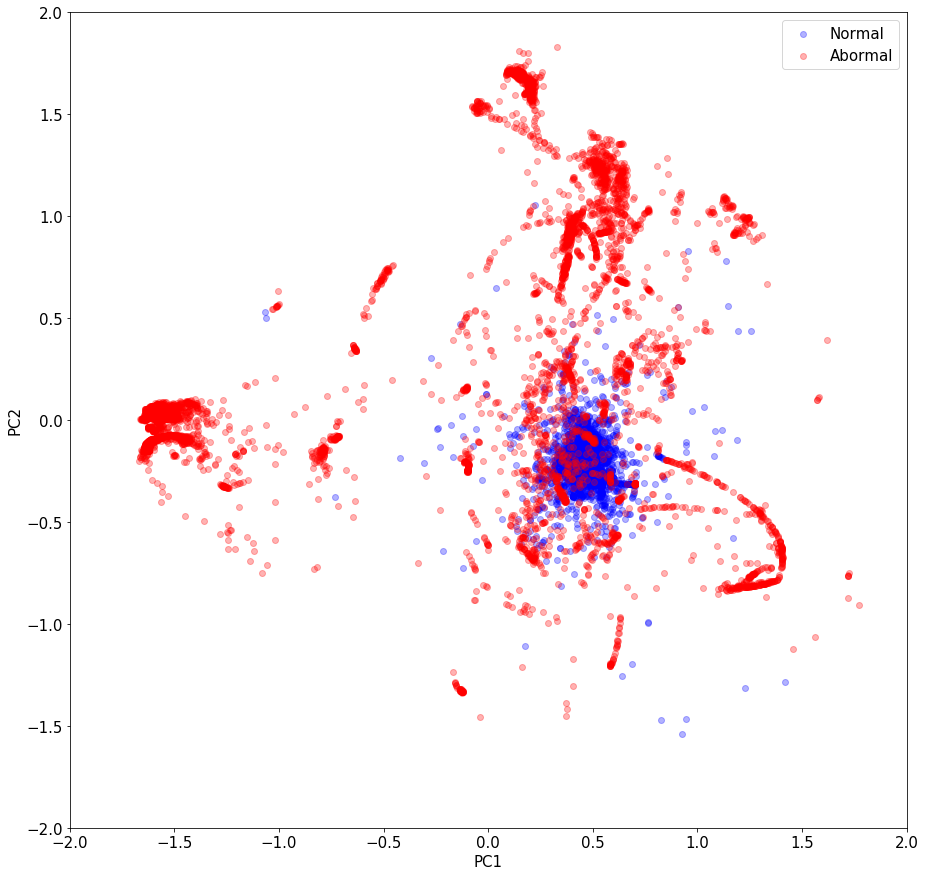

In [29]:
fig = plt.figure(figsize=(15, 15))

plt.scatter(
    x=list(map(lambda data: data[0], pca_normal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
plt.scatter(
    x=list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    y=list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)
plt.xlim(-2, 2)
plt.ylim(-2, 2)

font_size = 15

plt.xlabel("PC1", fontsize=font_size)
plt.ylabel("PC2", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size)

plt.savefig("./plot/oesae_margin05_latent_2d.png")

plt.show()

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)

pca.fit(best_latent_data_list)
pca_best_latent_data_list = pca.transform(best_latent_data_list)

pca_normal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in 
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 0
]
pca_abnormal_latent_data_list = [
    pca_best_latent_data for pca_best_latent_data, abnormal_label in
    zip(pca_best_latent_data_list, abnormal_label_list) if abnormal_label == 1
]

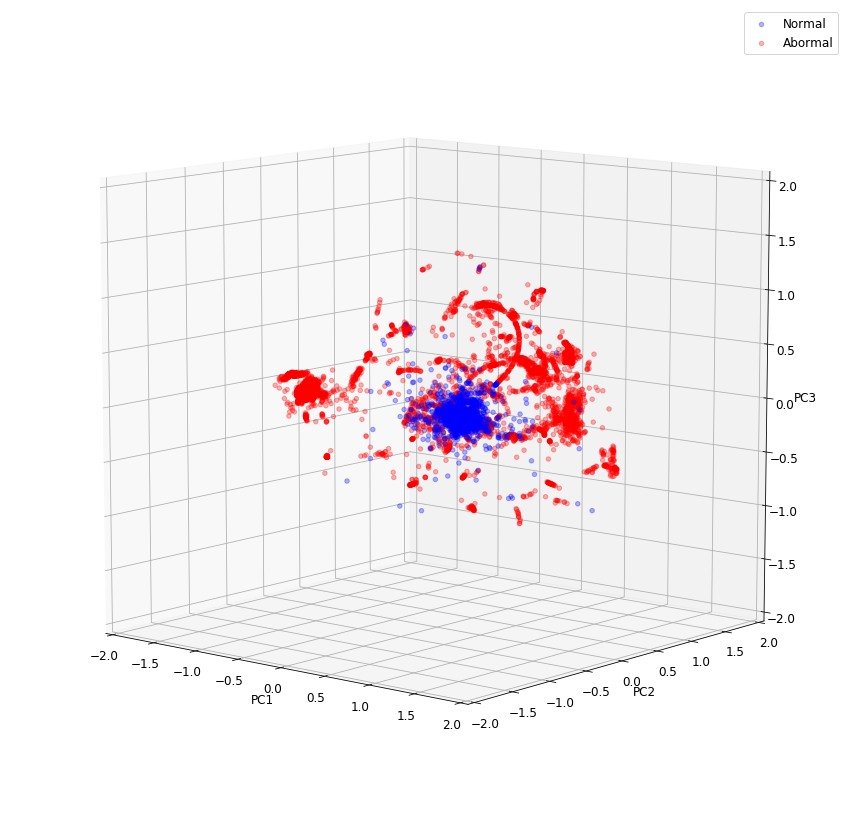

In [30]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

ax.scatter(
    list(map(lambda data: data[0], pca_normal_latent_data_list)),
    list(map(lambda data: data[1], pca_normal_latent_data_list)),
    list(map(lambda data: data[2], pca_normal_latent_data_list)),
    label="Normal",
    color="blue",
    alpha=0.3
)
ax.scatter(
    list(map(lambda data: data[0], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[1], pca_abnormal_latent_data_list)),
    list(map(lambda data: data[2], pca_abnormal_latent_data_list)),
    label="Abormal",
    color="red",
    alpha=0.3
)


ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

font_size = 12

ax.set_xlabel("PC1", fontsize=font_size)
ax.set_ylabel("PC2", fontsize=font_size)
ax.set_zlabel("PC3", fontsize=font_size)
ax.tick_params(axis="x", labelsize=font_size)
ax.tick_params(axis="y", labelsize=font_size)
ax.tick_params(axis="z", labelsize=font_size)
ax.legend(fontsize=font_size)


ax.view_init(elev=10., azim=310)

# ax.view_init(elev=10., azim=310)
plt.savefig("./plot/oesae_margin05_latent_3d.png")

plt.show()